# Individual Project


## Preparing the Data


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!spacy download en_core_web_sm
!spacy link en_core_web_sm en

spacy_en = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')

✘ Link 'en' already exists
To overwrite an existing link, use the --force flag



In [4]:
import re

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    res = []
    for tok in spacy_en.tokenizer(text):
        res.append(tok.text)
        if len(res)>512:
            break
    return res


In [5]:
TEXT = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


We then load the dataset and build the vocabulary.

In [7]:
from torchtext.data import Field, Example, TabularDataset, BucketIterator
import sys
import csv

fields = [('LABEL', TEXT), ('INPUT_TEXT', TEXT)]
train_data, valid_data,test_data = TabularDataset.splits(
    path='/content/drive/My Drive/pubmed/', format='csv',
    train='pm_train.csv',validation='pm_val.csv', test='pm_test.csv',
    skip_header=True, fields=fields)

In [8]:
TEXT.build_vocab(train_data, min_freq = 2)

Define the device and the data iterator.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
BATCH_SIZE = 4

train_iterator,valid_iterator,test_iterator = BucketIterator.splits(
    (train_data, valid_data,test_data), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

## Building the Model



In [11]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 10000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [15]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 10000
                 ):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
        #print('tok_embedding',self.tok_embedding(trg))
        #print('pos_embedding',self.pos_embedding(pos))   
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #print('enc_src size:',enc_src.shape)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model


In [18]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
HID_DIM = 256
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

print(INPUT_DIM)
print(OUTPUT_DIM)

169538
169538


In [19]:
SRC_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TRG_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 140,766,274 trainable parameters


In [21]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [22]:
model.apply(initialize_weights);

In [23]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [24]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.INPUT_TEXT
        trg = batch.LABEL
        
        optimizer.zero_grad()
        #print(src.shape)
        #print(trg.shape)
        output, _ = model(src, trg[:,:-1])
        #print(output.shape)
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.INPUT_TEXT
            trg = batch.LABEL

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1
LEARNING_RATE = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
best_valid_loss = float('inf')
train_loss_list = []
valid_loss_list = []
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/pubmed/transformer_pm_1.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} ')
    print(f'\tValid Loss: {valid_loss:.3f} ')


Epoch: 01 | Time: 33m 37s
	Train Loss: 6.660 
	Valid Loss: 5.858 
Epoch: 02 | Time: 33m 42s
	Train Loss: 5.699 
	Valid Loss: 5.452 
Epoch: 03 | Time: 33m 40s
	Train Loss: 5.336 
	Valid Loss: 5.256 


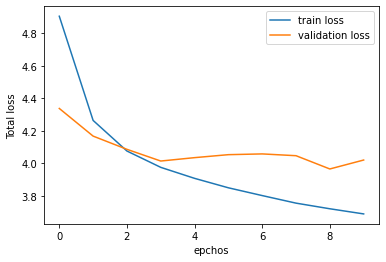

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(train_loss_list)),train_loss_list,label = 'train loss')
plt.plot(range(len(valid_loss_list)),valid_loss_list,label = 'validation loss')
plt.xlabel('epchos')
plt.ylabel('Total loss')
plt.legend()
plt.savefig('/content/drive/My Drive/pubmed/tf_tran_loss.png')

In [28]:


model.load_state_dict(torch.load('/content/drive/My Drive/pubmed/transformer_pm.pt'))

# test_loss = evaluate(model, valid_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

<All keys matched successfully>

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge
import numpy as np

rouge1_scores = []
rouge2_scores = []
rougel_scores = []
rouge = Rouge()
for example_idx in range(len(valid_data.examples)):
    src = vars(valid_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(valid_data.examples[example_idx])['LABEL']
    translation, attention = translate_sentence(src, TEXT, TEXT, model, device)
    reference = ' '.join(trg)
    prediction = ' '.join(translation)
    try:
        scores = rouge.get_scores(prediction, reference)
        rouge1_scores.append(scores[0]['rouge-1']['f'])
        rouge2_scores.append(scores[0]['rouge-2']['f'])
        rougel_scores.append(scores[0]['rouge-l']['f'])
    except:
        continue
print('ROUGE-1 score:{},std: {}'.format(np.mean(np.array(rouge1_scores)),np.std(np.array(rouge1_scores))))
print('ROUGE-2 score:{},std: {}'.format(np.mean(np.array(rouge2_scores)),np.std(np.array(rouge2_scores))))
print('ROUGE-l score:{},std: {}'.format(np.mean(np.array(rougel_scores)),np.std(np.array(rougel_scores))))
print(len(rouge1_scores))

ROUGE-1 score:0.21834715358912055,std: 0.07808335391667952
ROUGE-2 score:0.040924661736485325,std: 0.027976401733488573
ROUGE-l score:0.2241385393040221,std: 0.05917401041021015
2500


## Inference


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 512):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

An example.

In [ ]:
example_idx = 50

src = vars(test_data.examples[example_idx])['INPUT_TEXT']
trg = vars(test_data.examples[example_idx])['LABEL']
print(len(test_data.examples))
print(f'src = {src}')
print(f'trg = {trg}')

2500
src = ['the', 'nlrp3', 'inflammasome', ',', 'a', 'member', 'of', 'the', 'nlr', 'family', ',', 'is', 'a', 'key', 'player', 'in', 'the', 'production', 'of', 'uric', 'acid', '-', 'mediated', 'il-1', 'and', 'is', 'an', 'important', 'cytoplasmic', 'protein', 'complex', 'involved', 'in', 'gouty', 'inflammation', '(', '12', ')', '.', 'although', 'the', 'precise', 'pathogenic', 'mechanism', 'of', 'gout', 'has', 'not', 'been', 'clearly', 'determined', ',', 'several', 'crucial', 'proteins', 'such', 'as', 'the', 'purinergic', 'receptor', 'p2x', 'ligand', '-', 'gated', 'ion', 'channel', '7', '(', 'p2x7r', ')', '(', '345', ')', 'and', 'caspase', 'activation', 'and', 'recruitment', 'domain', '8', '(', 'card8', ')', '(', '67', ')', 'proteins', 'are', 'known', 'to', 'be', 'responsible', 'for', 'the', 'pathogenesis', 'of', 'gout', '.', 'recent', 'single', '-', 'nucleotide', 'polymorphism', '(', 'snp', ')', 'studies', 'suggested', 'that', 'genetic', 'alternations', 'of', 'several', 'target', 'molec

In [ ]:
translation, attention = translate_sentence(src, TEXT, TEXT, model, device)

print(f'predicted trg = {translation}')
reference = ' '.join(trg)
prediction = ' '.join(translation)

predicted trg = [' ', 'the', 'aim', 'of', 'this', 'study', 'was', 'to', 'investigate', 'the', 'association', 'between', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'in', 'the', 'susceptibility', 'to', 'the', 'inflammatory', '<unk>', 'and', '<unk>', '-', 'a', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'in', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'in', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'in', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'in', 'the', 'polymorphisms', 'of', 'the', 'polymorphisms', 'of', 'the', 'polymorphi

Compute ROUGE score.

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge
import numpy as np

rouge1_scores = []
rouge2_scores = []
rougel_scores = []
rouge = Rouge()
for example_idx in range(len(test_data.examples)):
    src = vars(test_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(test_data.examples[example_idx])['LABEL']
    translation, attention = translate_sentence(src, TEXT, LABEL, model, device)
    reference = ' '.join(trg)
    prediction = ' '.join(translation)
    try:
        scores = rouge.get_scores(prediction, reference)
        rouge1_scores.append(scores[0]['rouge-1']['f'])
        rouge2_scores.append(scores[0]['rouge-2']['f'])
        rougel_scores.append(scores[0]['rouge-l']['f'])
    except:
        continue
print('ROUGE-1 score:{}'.format(np.mean(np.array(rouge1_scores))))
print('ROUGE-2 score:{}'.format(np.mean(np.array(rouge2_scores))))
print('ROUGE-l score:{}'.format(np.mean(np.array(rougel_scores))))

ROUGE-1 score:0.4464429571609334
ROUGE-2 score:0.3223570913521733
ROUGE-l score:0.4142023281695927


Compute Number Recall/Precision.

In [ ]:
pip install word2number

In [ ]:
def tokenize_split(text):
    return text.split(' ')
def number_recall(pre,ref,n=4,threshold=0.7):
    prediction = pre
    reference = ref
    pre_num = []
    ref_num = []
    pre_toks = tokenize_split(prediction)
    ref_toks = tokenize_split(reference)
    pre_nums_count = 0
    ref_nums_count = 0
    # extract numbers in prediction
    for idx,tok in enumerate(pre_toks):
        numbers = re.findall(r'\d+[\,\d+]{1,}|\d+\.?\d+|\d+',tok)
        if(len(numbers)!=0):
            pre_nums_count += 1
            pre_num.append((numbers[0],idx))
        
    # extract numbers in reference
    for idx,tok in enumerate(ref_toks):
        numbers = re.findall(r'\d+[\,\d+]{1,}|\d+\.?\d+|\d+',tok)
        if(len(numbers)!=0):
            ref_nums_count += 1
            ref_num.append((numbers[0],idx))      
#     print('numbers in reference:{}'.format(ref_num))
#     print('')
#     print('numbers in prediction:{}'.format(pre_num))
    rec_num_count = 0
    rec_nums = []
    for r_num,r_idx in (ref_num):
        for p_num,p_idx in pre_num:
            if r_num == p_num:
                ref_info = []
                pre_info = []
                ref_info.append(ref_toks[r_idx])
                pre_info.append(pre_toks[p_idx])
                #提取两边的token
                n_gram = 1
                while n_gram<n+1 and r_idx-n_gram>=0 and p_idx-n_gram>=0:
                    ref_info.insert(0,ref_toks[r_idx-n_gram])
                    pre_info.insert(0,pre_toks[p_idx-n_gram])
                    n_gram += 1
                n_gram = 1
                while n_gram<n+1 and r_idx+n_gram<len(ref_toks) and p_idx+n_gram<len(pre_toks):
                    ref_info.append(ref_toks[r_idx+n_gram])
                    pre_info.append(pre_toks[p_idx+n_gram])
                    n_gram += 1
                if len(ref_info)==0 or len(pre_info)==0:
                    continue
                # tokens -> sentence
                rs = ' '.join(ref_info)
                ps = ' '.join(pre_info)
                # compute rouge scores and use f1 measure 
                rouge = Rouge()
                scores = rouge.get_scores(ps, rs)
                rg_f = 0
                for keys in scores[0]:
                    rg_f += scores[0][keys]['f']
                if rg_f/3>threshold:
                    rec_num_count += 1
                    rec_nums.append(r_num)
                    
                    break
    if ref_nums_count==0:
        rec_rate = False
    else:
        rec_rate = rec_num_count/ref_nums_count
    if pre_nums_count==0:
        pre_rate = False
    else:
        pre_rate = rec_num_count/pre_nums_count
    return rec_rate,pre_rate

In [ ]:
from rouge import Rouge
import numpy as np
num_rec_scores = []
num_pre_scores = []
rouge = Rouge()
for example_idx in range(len(valid_data.examples)):
    src = vars(valid_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(valid_data.examples[example_idx])['LABEL']
    translation, attention = translate_sentence(src, TEXT, TEXT, model, device)
    reference = ' '.join(trg)
    prediction = ' '.join(translation)
    # try:
    #     scores = number_recall(prediction,reference)
    #     if scores is False:
    #         continue
    #     num_rec_scores.append(scores)
    # except:
    #     continue
    scores,pre= number_recall(prediction,reference)
    if scores is False:
        a=1
    else:
        num_rec_scores.append(scores)
    if pre is False:
        a=1
    else:
        num_pre_scores.append(pre)
print('Number recall score:{}'.format(np.mean(np.array(num_rec_scores))))
print('Number recall score std:{}'.format(np.std(np.array(num_rec_scores))))
print('Number precision score:{}'.format(np.mean(np.array(num_pre_scores))))
print('Number precision score std:{}'.format(np.std(np.array(num_pre_scores))))


Number recall score:0.0008609399190753431
Number recall score std:0.011884427361945926
Number precision score:0.0054432896648321395
Number precision score std:0.08038143444250825
